In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir_ori = Path(r'Y:\coskun-lab\Thomas\15_PLA\data')
data_dir = data_dir = (Path().cwd().parents[0] / 'data').absolute()

# Get image dataframe 
df_imgs_path = data_dir_ori / 'OCT Mouse' / 'Whole' / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_imgs_path)


# Generate scatter plot

In [9]:
import napari 

# remove first and last consecutive zeros along dimension
def removeFirstAndLast(zeroArray):
    
    # remove first
    for ii, val in enumerate(zeroArray):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            lowest = ii # index of last of the first consecutive zeros
            
    # remove last
    for ii, val in enumerate(np.flip(zeroArray)):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            highest = len(zeroArray) - ii # index of first of the last consecutive zeros            
    
    return (lowest, highest)

# remove black borders from napari screenshot (2D image)
def removeBorders(RGB):
    rowMin = []
    rowMax = []
    colMin = []
    colMax = []
    for jj in range(3): # each RGB
        
        img = RGB[:, :, jj]
        # find first and last rows and cols of all zeros
        # remove any rows of zeros
        zeroRows = np.all(img == 0, axis = 1)
        zeroCols = np.all(img == 0, axis = 0)

        posRows = removeFirstAndLast(zeroRows)
        posCols = removeFirstAndLast(zeroCols)            
        
        rowMin.append(posRows[0])
        rowMax.append(posRows[1])
        colMin.append(posCols[0])
        colMax.append(posCols[1])
        
    # make sure border signal is not cut out
    rowMin = np.min(rowMin)
    rowMax = np.max(rowMax)
    colMin = np.min(colMin)
    colMax = np.max(colMax)
        
    cropped = RGB[rowMin: rowMax, colMin: colMax, :] 
    
    return cropped

def get_loc_ppi(df, Condition, FOV, x_min, y_min, x_max, y_max, PPI_name):
    df_ppi = df[(df.Condition == Condition) & (df.FOV == FOV)]
    df_ppi = df_ppi[df_ppi.PPI == PPI_name]
    df_ppi = df_ppi[(df_ppi.column > x_min) & (df_ppi.column < x_max) 
                    & (df_ppi.row > y_min) & (df_ppi.row < y_max)] 
    points = df_ppi[['row', 'column']].to_numpy()
    points = points - np.array([y_min, x_min])
    return points

In [10]:
df_imgs

,Timepoint,FOV,Path
0,1M,FW1,Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...
1,1M,FW2,Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...
2,1W,FW1,Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...
3,1W,FW2,Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...
4,1W,FW3,Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...


In [11]:
# Read PPI
PPI_save_path =  Path(r'Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Whole\PPI')

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

In [12]:
PPI_cycles = [['TEAD1 & YAP1'], ['CylinE & CDK2'],
       ['P-ERK & c-MYC'], ['p-AKT & mTOR'],
       [ 'Mcl-1 & BAK']]

## 1W plot

In [8]:
# Get images
index = 2
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']


Timepoint                                                   1W
FOV                                                        FW1
Path         Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...
Name: 2, dtype: object


In [16]:
df.PPI.unique()

array(['TEAD1 & YAP1', 'CylinE & CDK2', 'P-ERK & c-MYC', 'p-AKT & mTOR',
       'Mcl-1 & BAK'], dtype=object)

In [26]:
df.columns = ['Cyto', 'row', 'column',  'PPI', 'Nuclei', 'Condition', 'FOV']

image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'PLA_scatter'
image_dir.mkdir(parents=True, exist_ok=True)

# Define matching bbox to figures
x1, y1 = 3340, 7272
x_min, y_min = 109, 409
x_max, y_max = 300, 523
x_min += x1
x_max += x1
y_min += y1
y_max += y1
DAPI_ch = 0

In [27]:
# # Get ppi location
# points = get_loc_ppi(df, row.Timepoint, row.FOV, x_min, y_min, x_max, y_max, 'CylinE & CDK2') 

# # Napari viewerdd
# # Napari 
# viewer = napari.view_image(imgs[[0,list(markers).index('CylinE & CDK2')], y_min:y_max, x_min:x_max], channel_axis=0, colormap=['blue', 'magenta',], contrast_limits=[[0, 1], [0, 0.18]])
# points_layer = viewer.add_points(points, size=8,face_color='lime')

In [28]:
# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]

colors = ['magenta']
# Get ppi location
for i, PPI_names in enumerate(PPI_cycles):
    points = [get_loc_ppi(df, row.Timepoint, row.FOV, x_min, y_min, x_max, y_max, PPI_name) for PPI_name in PPI_names]

    # Napari viewer
    viewer = napari.view_image(dapiImg, colormap='blue')
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=8,face_color=colors[j],)

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'xenograft_1W_{i}.tif', removeBorders(screenshot))


C:\Users\thu71\AppData\Local\Temp\ipykernel_32088\2384667927.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_1W_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_32088\2384667927.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_1W_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_32088\2384667927.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_1W_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_32088\2384667927.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_1W_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_32088\2384667927.py:18: DeprecationWarning: <tifffile.imsave> is deprecated.

## 2M plot

In [29]:
# Get images
index = 0
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']


Timepoint                                                   1M
FOV                                                        FW1
Path         Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...
Name: 0, dtype: object


In [30]:
df.PPI.unique()

array(['TEAD1 & YAP1', 'CylinE & CDK2', 'P-ERK & c-MYC', 'p-AKT & mTOR',
       'Mcl-1 & BAK'], dtype=object)

In [34]:
df.columns = ['Cyto', 'row', 'column',  'PPI', 'Nuclei', 'Condition', 'FOV']

image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'PLA_scatter'
image_dir.mkdir(parents=True, exist_ok=True)

# Define matching bbox to figures
x1, y1 = 1110, 2532
x_min, y_min = 942, 550
x_max, y_max = 1115,728
x_min += x1
x_max += x1
y_min += y1
y_max += y1
DAPI_ch = 0

In [35]:
# # Get ppi location
# points = get_loc_ppi(df, row.Timepoint, row.FOV, x_min, y_min, x_max, y_max, 'CylinE & CDK2') 

# # Napari viewerdd
# # Napari 
# viewer = napari.view_image(imgs[[0,list(markers).index('CylinE & CDK2')], y_min:y_max, x_min:x_max], channel_axis=0, colormap=['blue', 'magenta',], contrast_limits=[[0, 1], [0, 0.18]])
# points_layer = viewer.add_points(points, size=8,face_color='lime')

In [36]:
# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]

colors = ['magenta']
# Get ppi location
for i, PPI_names in enumerate(PPI_cycles):
    points = [get_loc_ppi(df, row.Timepoint, row.FOV, x_min, y_min, x_max, y_max, PPI_name) for PPI_name in PPI_names]

    # Napari viewer
    viewer = napari.view_image(dapiImg, colormap='blue')
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=8,face_color=colors[j],)

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'xenograft_2M_{i}.tif', removeBorders(screenshot))


C:\Users\thu71\AppData\Local\Temp\ipykernel_32088\3681807745.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_2M_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_32088\3681807745.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_2M_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_32088\3681807745.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_2M_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_32088\3681807745.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_2M_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_32088\3681807745.py:18: DeprecationWarning: <tifffile.imsave> is deprecated.

## 1W plot 2

In [13]:
df_imgs

,Timepoint,FOV,Path
0,1M,FW1,Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...
1,1M,FW2,Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...
2,1W,FW1,Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...
3,1W,FW2,Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...
4,1W,FW3,Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...


In [14]:
# Get images
index = 2
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']


Timepoint                                                   1W
FOV                                                        FW1
Path         Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...
Name: 2, dtype: object


In [15]:
df.PPI.unique()

array(['TEAD1 & YAP1', 'CylinE & CDK2', 'P-ERK & c-MYC', 'p-AKT & mTOR',
       'Mcl-1 & BAK'], dtype=object)

In [16]:
df.columns = ['Cyto', 'row', 'column',  'PPI', 'Nuclei', 'Condition', 'FOV']

image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'PLA_scatter'
image_dir.mkdir(parents=True, exist_ok=True)

# Define matching bbox to figures
x_min, y_min = 3353,7298
x_max, y_max = 4091,7938
DAPI_ch = 0

In [17]:
# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]

colors = ['magenta']
# Get ppi location
for i, PPI_names in enumerate(PPI_cycles):
    points = [get_loc_ppi(df, row.Timepoint, row.FOV, x_min, y_min, x_max, y_max, PPI_name) for PPI_name in PPI_names]

    # Napari viewer
    viewer = napari.view_image(dapiImg, colormap='blue')
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=8,face_color=colors[j],)

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'xenograft_big_1W_{i}.tif', removeBorders(screenshot))


C:\Users\thu71\AppData\Local\Temp\ipykernel_45860\2381173882.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_big_1W_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_45860\2381173882.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_big_1W_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_45860\2381173882.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_big_1W_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_45860\2381173882.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_big_1W_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_45860\2381173882.py:18: DeprecationWarning: <tifffile.imsave

## 2M plot 2

In [18]:
# Get images
index = 0
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']


Timepoint                                                   1M
FOV                                                        FW1
Path         Y:\coskun-lab\Thomas\15_PLA\data\OCT mouse\Who...
Name: 0, dtype: object


In [19]:
df.PPI.unique()

array(['TEAD1 & YAP1', 'CylinE & CDK2', 'P-ERK & c-MYC', 'p-AKT & mTOR',
       'Mcl-1 & BAK'], dtype=object)

In [20]:
df.columns = ['Cyto', 'row', 'column',  'PPI', 'Nuclei', 'Condition', 'FOV']

image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'PLA_scatter'
image_dir.mkdir(parents=True, exist_ok=True)

# Define matching bbox to figures
x_min, y_min = 1117,2551
x_max, y_max = 2647,4057
DAPI_ch = 0

In [21]:
# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]

colors = ['magenta']
# Get ppi location
for i, PPI_names in enumerate(PPI_cycles):
    points = [get_loc_ppi(df, row.Timepoint, row.FOV, x_min, y_min, x_max, y_max, PPI_name) for PPI_name in PPI_names]

    # Napari viewer
    viewer = napari.view_image(dapiImg, colormap='blue')
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=8,face_color=colors[j],)

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'xenograft_big_2M_{i}.tif', removeBorders(screenshot))


C:\Users\thu71\AppData\Local\Temp\ipykernel_45860\1924654263.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_big_2M_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_45860\1924654263.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_big_2M_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_45860\1924654263.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_big_2M_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_45860\1924654263.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'xenograft_big_2M_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_45860\1924654263.py:18: DeprecationWarning: <tifffile.imsave

# Quantification 9PPI

## Statistical plot

In [5]:
# Read PPI
PPI_save_path =  Path(r'Y:\coskun-lab\Thomas\15_PLA\data\OCT Mouse\Whole\PPI')

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Get nuclei and cell count
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']
df_cell = (df_cell.pivot_table(values='Count_cell', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_cell', var_name='PPI')
)

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']
df_nuclei = (df_nuclei.pivot_table(values='Count_nuclei', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_nuclei', var_name='PPI')
)

# Combine count
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)
df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei'],'Count_cell'] = df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei']]['Count_nuclei']
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [6]:
rename_dict = {'1M': '2M', '1W': '1W'}
df_all['Condition'] = df_all['Condition'].apply(lambda x: rename_dict.get(x,x))

In [7]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe().to_excel('data.xlsx')

In [8]:
# Filter out by maximum number of counts per cell
min_count = 5
max_count = 40

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


C:\Users\thu71\AppData\Local\Temp\ipykernel_633984\2887501683.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


,Count_cell,Count_nuclei,Count_cyto
count,44219.000000,44219.000000,44219.000000
mean,23.504421,9.643321,13.861100
std,17.099260,10.275391,10.903776
min,6.000000,0.000000,0.000000
25%,11.000000,3.000000,6.000000
50%,18.000000,7.000000,11.000000
75%,32.000000,13.000000,19.000000
max,176.000000,157.000000,114.000000


In [9]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe().to_clipboard()

In [10]:
from statannotations.Annotator import Annotator

def plot(plotting, figsize=(10,7), y_title='Count PPI per cell'):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
        result = annot.apply_test().annotate()
        ax.set_ylabel(y_title, fontsize=40)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## Comparison between condition

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mcl-1 & BAK_2M vs. Mcl-1 & BAK_1W: Mann-Whitney-Wilcoxon test two-sided, P_val:3.862e-225 U_stat=1.975e+08
CylinE & CDK2_2M vs. CylinE & CDK2_1W: Mann-Whitney-Wilcoxon test two-sided, P_val:1.943e-43 U_stat=2.559e+08
P-ERK & c-MYC_2M vs. P-ERK & c-MYC_1W: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.267e+08
TEAD1 & YAP1_2M vs. TEAD1 & YAP1_1W: Mann-Whitney-Wilcoxon test two-sided, P_val:2.523e-01 U_stat=2.361e+08
p-AKT & mTOR_2M vs. p-AKT & mTOR_1W: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.298e+08


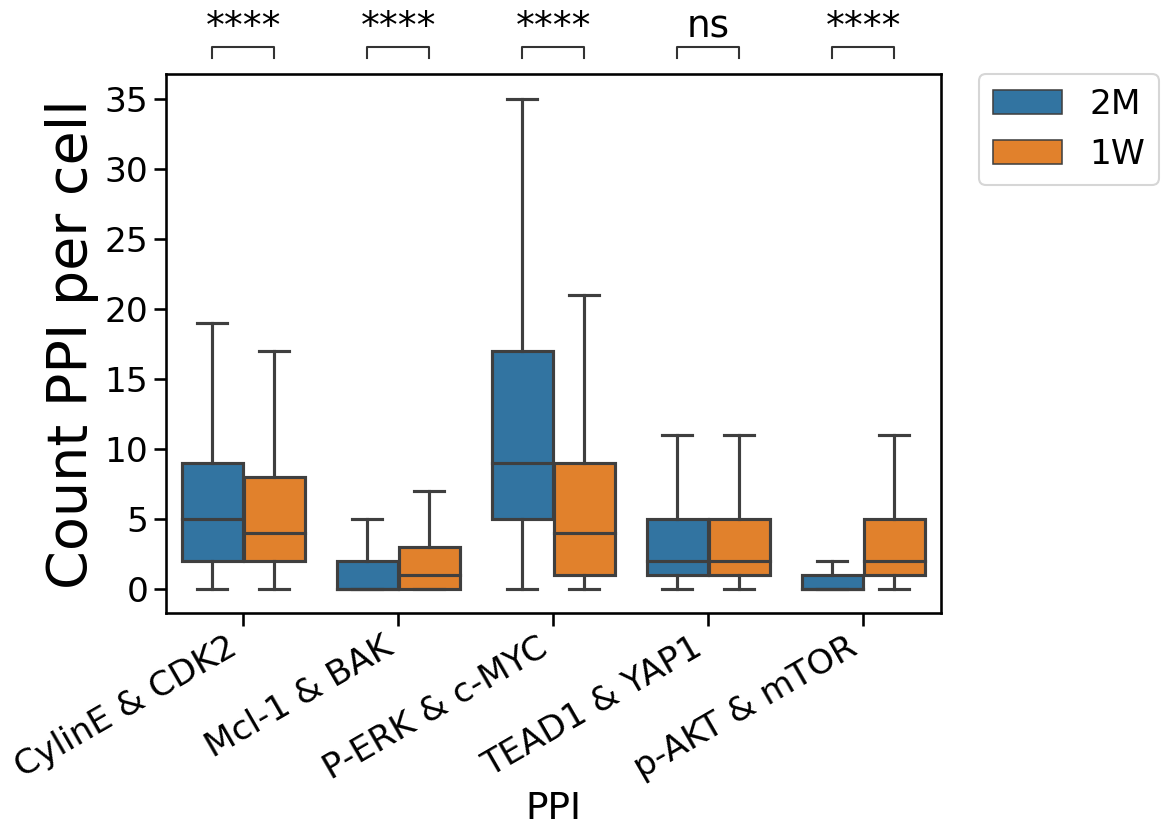

In [11]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition",
    "hue_order": ['2M', '1W'],
}

plot(plotting)

In [12]:
df_all.groupby('PPI')['Count_cell'].describe().to_clipboard()

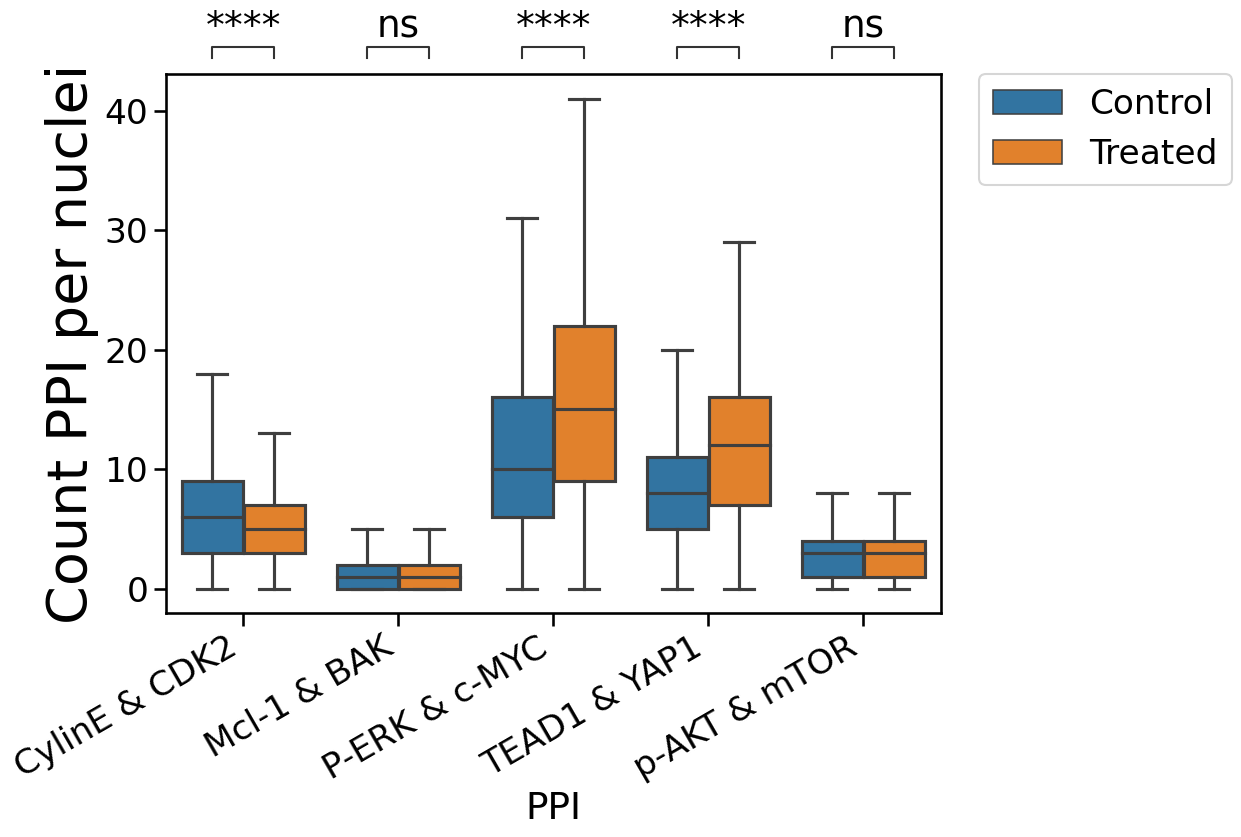

In [12]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_nuclei",
    "hue": "Condition",
    "hue_order": ['Control', 'Treated'],
}

plot(plotting, y_title='Count PPI per nuclei')

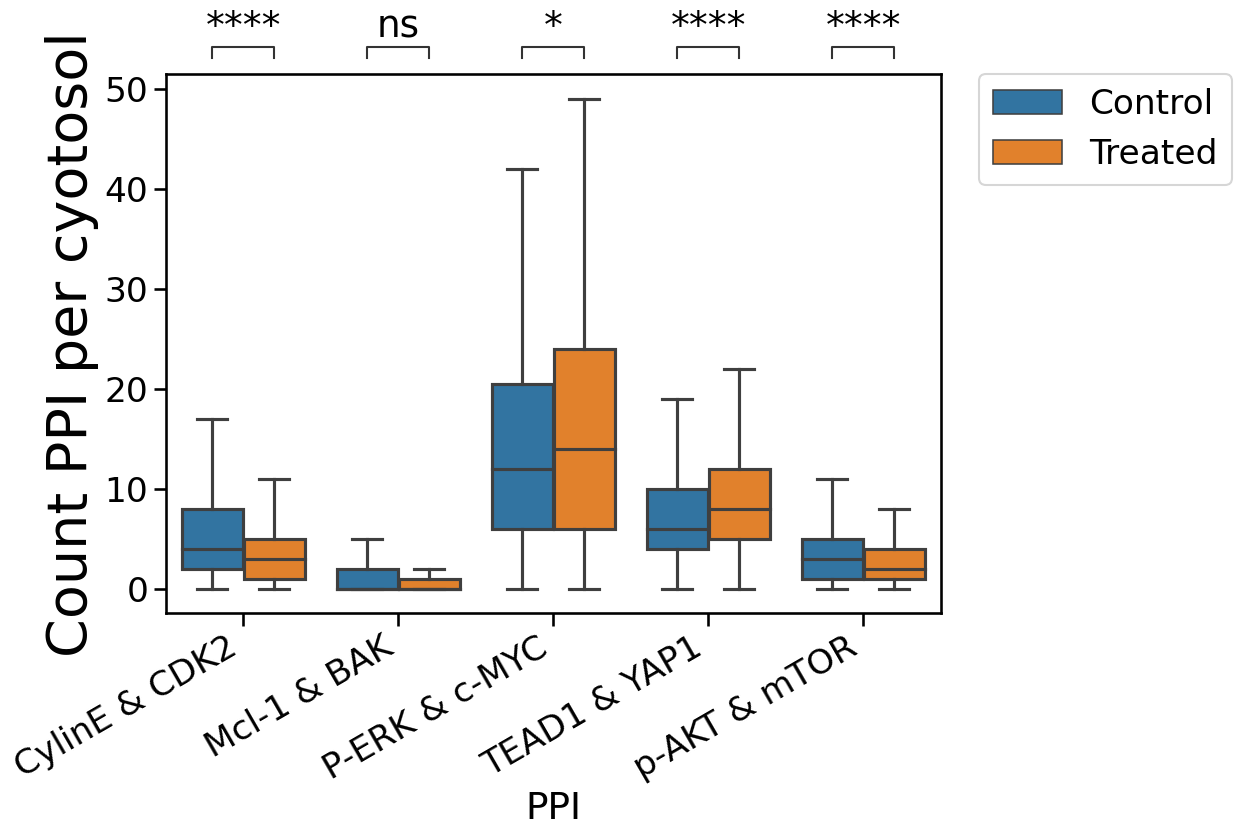

In [13]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cyto",
    "hue": "Condition",
    "hue_order": ['Control', 'Treated'],
}

plot(plotting, y_title='Count PPI per cyotosol')

## Combined statistics

In [19]:
df_combined = df_all.groupby(['Condition', 'FOV', 'Id'])[['Count_cell', 'Count_nuclei', 'Count_cyto']].agg('sum').reset_index()

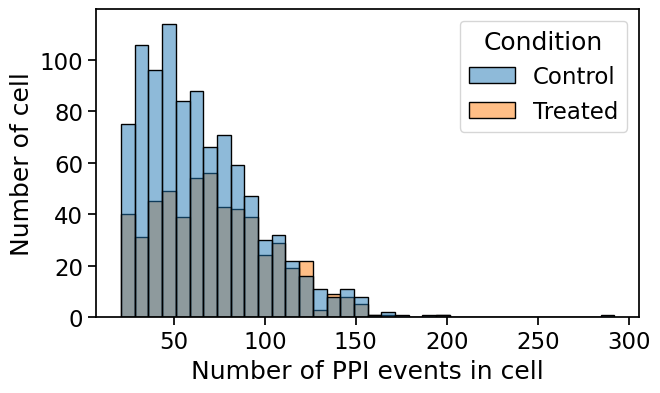

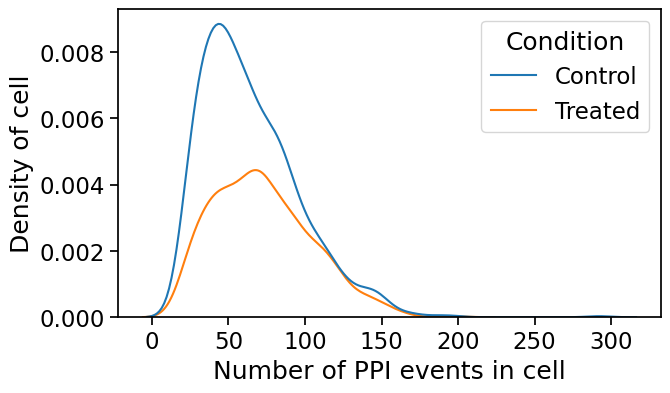

In [20]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.histplot(data=df_combined, x='Count_cell', hue='Condition', ax=ax)
    ax.set_ylabel('Number of cell')
    ax.set_xlabel('Number of PPI events in cell')

# Plot kde
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(data=df_combined, x='Count_cell', hue='Condition', ax=ax)
    ax.set_ylabel('Density of cell')
    ax.set_xlabel('Number of PPI events in cell')    

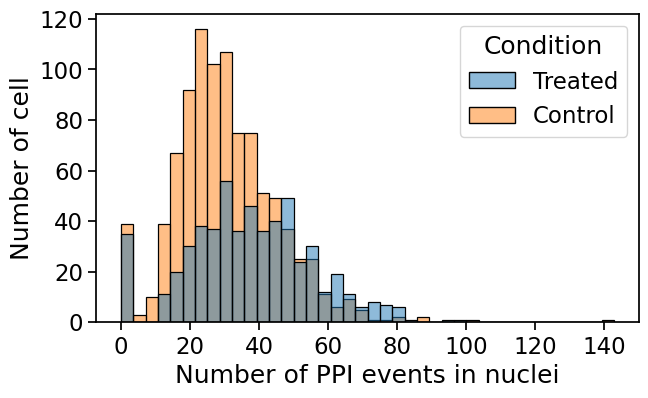

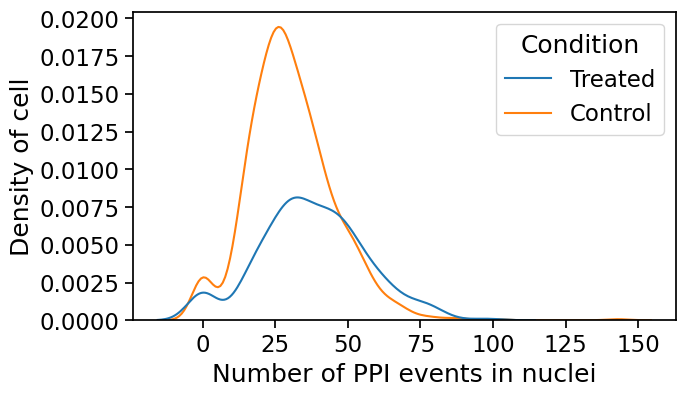

In [21]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.histplot(data=df_combined, x='Count_nuclei', hue='Condition', ax=ax,
                hue_order= ['Treated', 'Control'],)
    ax.set_ylabel('Number of cell')
    ax.set_xlabel('Number of PPI events in nuclei')

# Plot kde
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(data=df_combined, x='Count_nuclei', hue='Condition', ax=ax,
                hue_order= ['Treated', 'Control'],)
    ax.set_ylabel('Density of cell')
    ax.set_xlabel('Number of PPI events in nuclei')    

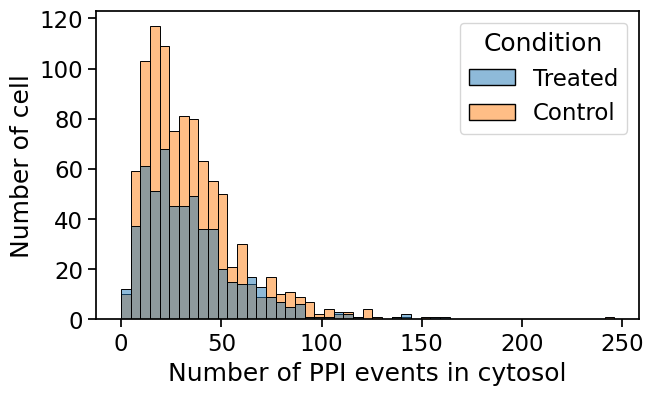

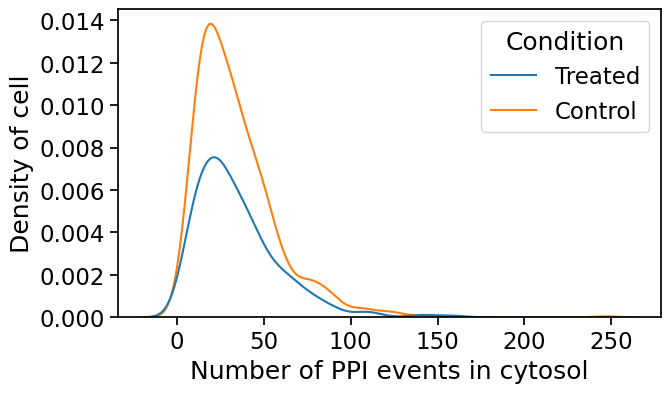

In [22]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.histplot(data=df_combined, x='Count_cyto', hue='Condition', ax=ax,
                 hue_order= ['Treated', 'Control'],)
    ax.set_ylabel('Number of cell')
    ax.set_xlabel('Number of PPI events in cytosol')

# Plot kde
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(data=df_combined, x='Count_cyto', hue='Condition', ax=ax,
                hue_order= ['Treated', 'Control'],)
    ax.set_ylabel('Density of cell')
    ax.set_xlabel('Number of PPI events in cytosol')    

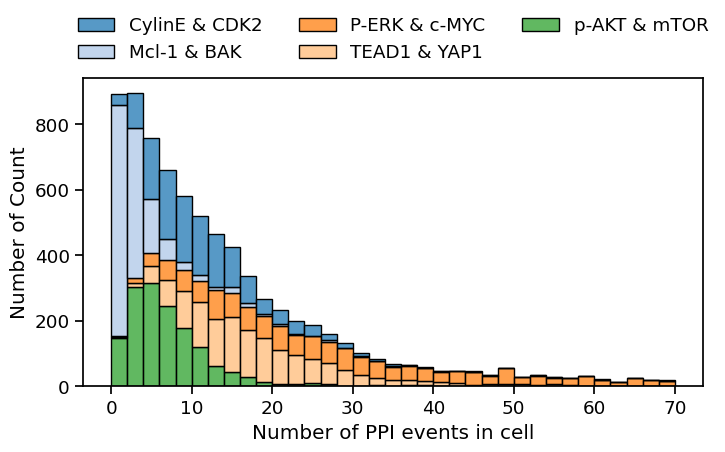

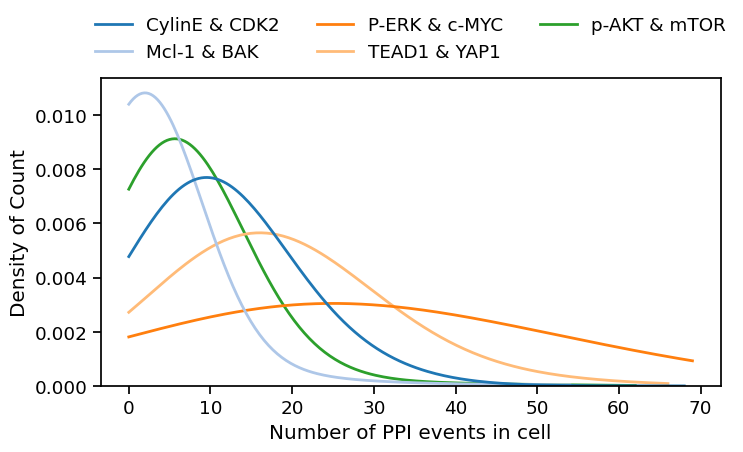

In [23]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.2):
    fig, ax = plt.subplots(figsize=(8,4))
    sns.histplot(data=df_all, x='Count_cell', hue='PPI', ax=ax, multiple="stack", palette='tab20', binwidth=2)
    ax.set_ylabel('Number of Count')
    ax.set_xlabel('Number of PPI events in cell')
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)


# Plot kde
with sns.plotting_context("notebook", font_scale=1.2):
    fig, ax = plt.subplots(figsize=(8,4))
    sns.kdeplot(data=df_all, x='Count_cell', hue='PPI', ax=ax, palette='tab20', cut=0, bw_adjust=5, lw=2)
    ax.set_ylabel('Density of Count')
    ax.set_xlabel('Number of PPI events in cell')    
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

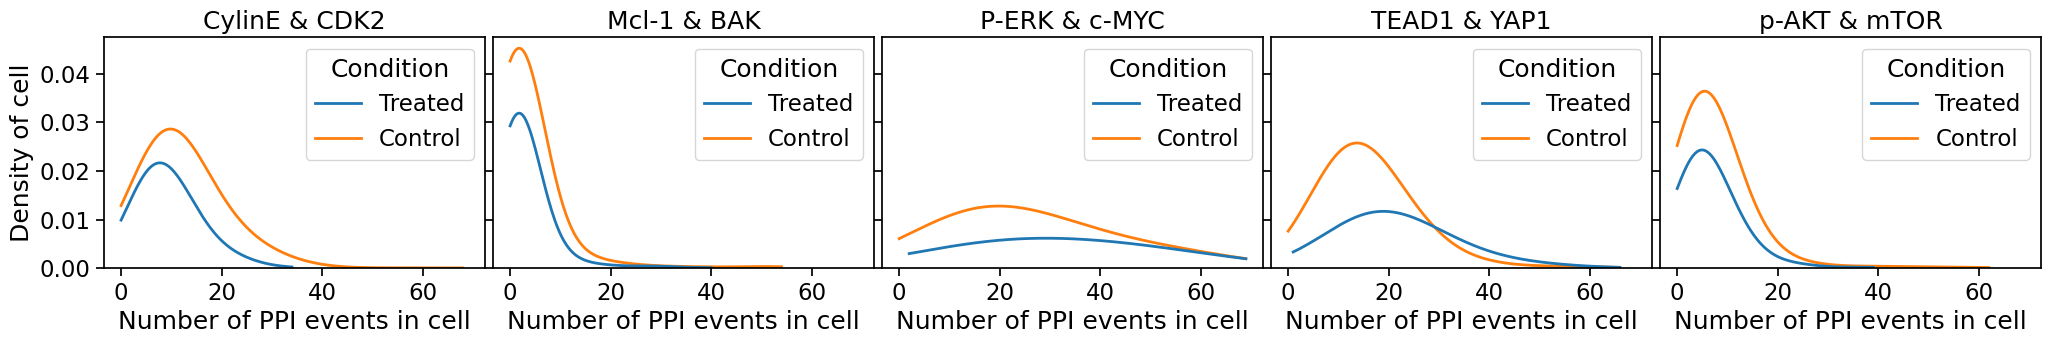

In [25]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, axs = plt.subplots(1, 5, figsize=(25,3), sharex=True, sharey=True)
    axs = axs.flatten()
    for i, PPI in enumerate(df_all.PPI.unique()):
        df_subset = df_all[df_all.PPI == PPI]
        # Plot kde
        sns.kdeplot(data=df_subset, x='Count_cell', hue='Condition', ax=axs[i], 
                    hue_order= ['Treated', 'Control'], cut=0, bw_adjust=3, lw=2)
        axs[i].set_title(PPI)
        if i % 4 == 0:
            axs[i].set_ylabel('Density of cell')
        axs[i].set_xlabel(f'Number of PPI events in cell')
    fig.subplots_adjust(wspace=0.02)
    plt.show()